# Introduction

**BERT** - an encoder-only model based on the Transformer and attention architecture. Pretrained for masked language modelling and next sentence prediction. DistilBERT is a smaller version of BERT.

**RoBERTa** - optimised with 1) removing the Next Sentence Prediction pre-training objective, 2) use mini-batches with a larger size, 3) with a higher learning rate, 4) for more epochs, 5) much much more data, and lastly, 6) they also changed the tokenization method to byte-level BPE.

**GPT** - architecture is based on the Transformer’s decoder block. The encoder-decoder cross attention part of the block is removed because there is no encoder, and the self-attention part is replaced with the masked self-attention.

# Simple HuggingFace Translation / Summarisation / Generation

**T5-Base** - for English to German translation and then using Bert2Bert model for German to English translation. The T5 model was presented in Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer.

T5 is an encoder-decoder model pre-trained on a multi-task mixture of unsupervised and supervised tasks and for which each task is converted into a text-to-text format. T5 works well on a variety of tasks out-of-the-box by prepending a different prefix to the input corresponding to each task. E.g. translate then summarise...

**BART** - one of the best pre-trained models for summarization. (BART) can be seen as generalizing Bert (due to the bidirectional encoder) and GPT2 (with the left to right decoder). Bert is pretrained to try to predict masked tokens.

They used noising functions like Token Masking, Token Deletion, Token Infilling, Sentence Shuffling, and Document Rotation to prepare the encoder’s noisy input. Then an autoregressive decoder tries to recreate the original input (or denoise it).

https://pub.towardsai.net/a-full-introduction-on-text-summarization-using-deep-learning-with-sample-code-ft-huggingface-d21e0336f50c

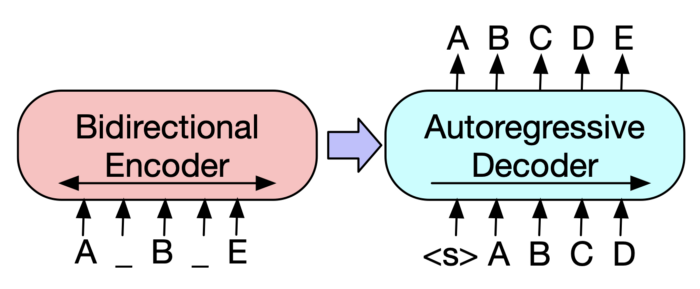

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

1) Build model pipeline to translate from English to German with t5-base. No need for tokenizer. 2) Then German to English with normal Bert model; tokenize with AutoTokenizer.

In [ ]:
#English to German using the Pipeline and T5
translator_en_to_de = pipeline("translation_en_to_de", model='t5-base')

In [ ]:
#German to English using Bert2Bert model
tokenizer = AutoTokenizer.from_pretrained("google/bert2bert_L-24_wmt_de_en", pad_token="<pad>", eos_token="</s>", bos_token="<s>")
model_de_to_en = AutoModelForSeq2SeqLM.from_pretrained("google/bert2bert_L-24_wmt_de_en")

In [ ]:
input_text = "I went to see a movie in the theater"
en_to_de_output = translator_en_to_de(input_text)
translated_text = en_to_de_output[0]['translation_text']
print("Translated text->",translated_text)

In [ ]:
input_ids = tokenizer(translated_text, return_tensors="pt", add_special_tokens=False).input_ids
output_ids = model_de_to_en.generate(input_ids)[0]
augmented_text = tokenizer.decode(output_ids, skip_special_tokens=True)
print("Augmented Text->",augmented_text)

## 1. BART Summarisation

Developed by Facebook. It contains 1024 hidden layers and 406M parameters and has been fine-tuned using CNN, a news summarization dataset.

In [ ]:
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

The BART model has three main components: encoder (12 layers), decoder (12 layers), and lm_head (we call it the Linear Layer). You can easily use specific parts of the architecture by calling them like model.model.encoder, model.model.decoder, and model.lm_head. However, Huggingface has built-in functions to access the encoder and decoder with a bit more flexibility.

In [ ]:
from transformers import BartTokenizer
ARTICLE_TO_SUMMARIZE = """sebastian vettel is determined to ensure the return of a long-standing ritual at ferrari is not a one-off this season. fresh from ferrari's first victory in 35 grands prix in malaysia 11 days ago, and ending his own 20-race drought, vettel returned to a hero's welcome at the team's factory at maranello last week. the win allowed ferrari to revive a tradition not seen at their base for almost two years since their previous triumph in may 2013 at the spanish grand prix courtesy of fernando alonso. sebastian vettel reflected on his stunning win for ferrari at the malaysian grand prix during the press conference before the weekend's chinese grand prix in shanghai the four-time world champion shares a friendly discussion with mclaren star jenson button four-times world champion vettel said: 'it was a great victory we had in malaysia, great for us as a team, and for myself a very emotional day - my first win with ferrari. 'when i returned to the factory on wednesday, to see all the people there was quite special. there are a lot of people working there and as you can imagine they were very, very happy. 'the team hadn't won for quite a while, so they enjoyed the fact they had something to celebrate. there were a couple of rituals involved, so it was nice for them to get that feeling again.' asked as to the specific nature of the rituals, vettel replied: 'i was supposed to be there for simulator work anyway, but it was quite nice to receive the welcome after the win. ferrari's vettel and britta roeske arrive at the shanghai circuit along with a ferrari mechanic, vettel caught up with members of his old team red bull on thursday 'all the factory got together for a quick lunch. it was quite nice to have all the people together in one room - it was a big room! - so we were able to celebrate altogether for a bit. 'i also learned when you win with ferrari, at the entry gate, they raise a ferrari flag - and obviously it's been a long time since they last did that. 'some 10 years ago there were a lot of flags, especially at the end of a season, so this flag will stay there for the rest of the year. 'we will, of course, try and put up another one sometime soon.' inside the ferrari garage, vettel shares a discussion with team staff as he looks to build on his sepang win ferrari team principal maurizio arrivabene shares a conversation with vettel at the team's hospitality suite the feeling is that will not happen after this weekend's race in china as the conditions at the shanghai international circuit are expected to suit rivals mercedes. not that vettel believes his success will be a one-off, adding: 'for here and the next races, we should be able to confirm we have a strong package and a strong car. 'we will want to make sure we stay ahead of the people we were ahead of in the first couple of races, but obviously knowing mercedes are in a very, very strong position. 'in general, for the start of a season things can be up and down, and we want to make sure there is quite a lot of ups, not so many downs. 'but it's normal in some races you are more competitive than others. 'we managed to do a very good job in malaysia, but for here and the next races we have to be realistic about we want to achieve.' ferrari mechanics show their joy after vettel won the malaysian grand prix, helping record the team's first formula one win since 2013 at the spanish grand prix"""

tokenized_input = tokenizer([ARTICLE_TO_SUMMARIZE], max_length=1024, truncation=True, return_tensors='pt')

### Step-by-Step 

**The following can be automated with Generate but we can demonstrate this step by step.** Provide input data to the encoder and masking if applicable.

In [ ]:
the_encoder = model.get_encoder()
the_decoder = model.get_decoder()
last_linear_layer = model.lm_head

In [ ]:
input_representation = the_encoder(input_ids = tokenized_input.input_ids,
                                   attention_mask = tokenized_input.attention_mask)

The decoder component is the unit responsible for generating the summary. The generation process starts by passing the bos (beginning of the sentence) token to initiate the process and goes on one token at a time to complete the summary. 

In [ ]:
start_token = torch.tensor([tokenizer.bos_token_id]).unsqueeze(0)
mask_ids = torch.tensor([1]).unsqueeze(0)

In [ ]:
decoder_output = the_decoder(input_ids=start_token,
                             attention_mask=mask_ids,
                             encoder_hidden_states=input_representation[0],
                             encoder_attention_mask=tokenized_input.attention_mask )
decoder_output = decoder_output.last_hidden_state

The logits.argmax will pick the most probable token from all the probabilities and returns the token id.

In [ ]:
logits = last_linear_layer(decoder_output[0])
predicted_token = logits.argmax(1)

### Using Generate

Huggingface’s built-in function that takes care of this repetitive task.

In [ ]:
summary_ids = model.generate(tokenized_input['input_ids'], max_length=15, early_stopping=True)
print([tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids])

## 2. Simple T5 Summarization

**Tokenize, and Generate with T5 and GPT to produce desired output.**




In [ ]:
import torch
import json 
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')

In [ ]:
text ="""
The US has "passed the peak" on new coronavirus cases, President Donald Trump said and predicted that some states would reopen this month.
The US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths, the highest for any country in the world.
At the daily White House coronavirus briefing on Wednesday, Trump said new guidelines to reopen the country would be announced on Thursday after he speaks to governors.
"We'll be the comeback kids, all of us," he said. "We want to get our country back."
The Trump administration has previously fixed May 1 as a possible date to reopen the world's largest economy, but the president said some states may be able to return to normalcy earlier than that.
"""


In [ ]:
preprocess_text = text.strip().replace("\n","")
t5_prepared_Text = "summarize: "+preprocess_text
print ("original text preprocessed: \n", preprocess_text)

Encode preprocessed text and give as tensors (Pytorch tensor). Then use model.generate on the tokenized text (with ngram size, min_length, max_length) to produce the summarised result. 

In [ ]:
tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt")

In [ ]:
# summmarize 
summary_ids = model.generate(tokenized_text,
                                    num_beams=4,
                                    no_repeat_ngram_size=2,
                                    min_length=30,
                                    max_length=100,
                                    early_stopping=True)

And finally, decode with tokenizer to give the output summary.

In [ ]:
output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [ ]:
print ("\n\nSummarized text: \n",output)

## 3. Simple Text Generation with GPT2

In [ ]:
!pip install transformers

In [ ]:
from transformers import pipeline
generator = pipeline('text-generation', model='gpt2')

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
input_text = "I went to see a movie in the theater"
input_length = len(input_text.split())
num_new_words = 5

In [ ]:
output_length = input_length + num_new_words

Again use generator with specified parameters to give output.

In [ ]:
gpt_output = generator(input_text, max_length=output_length, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
augmented_text = gpt_output[0]['generated_text']

In [ ]:
augmented_text

'I went to see a movie in the theater and was so nervous.'

## 4. Train BERT Classification

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
path = "/content/drive/My Drive/HuggingFaceTrain"

In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
dataset = load_dataset('csv', data_files={'train': path+'/Corona_NLP_train.csv', 'test': path+'/Corona_NLP_test.csv'}, encoding = "ISO-8859-1")

In [ ]:
dataset

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [ ]:
tokenizer("Attention is all you need")

In [ ]:
# Convert sentiment into integer and tokenize the tweets
def transform_labels(label):
    label = label['Sentiment']
    num = 0
    if label == 'Positive':
      num = 0
    elif label == 'Negative':
      num = 1
    elif label == 'Neutral':
      num = 2
    elif label == 'Extremely Positive':
      num = 3
    elif label == 'Extremely Negative':
      num = 4
    return {'labels': num}

In [ ]:
def tokenize_data(example):
    return tokenizer(example['OriginalTweet'], padding='max_length')

Use of map to apply purpose built function on specific columns - and do batches and remove_columns.

In [ ]:
dataset = dataset.map(tokenize_data, batched=True)

In [ ]:
remove_columns = ['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet', 'Sentiment']
dataset = dataset.map(transform_labels, remove_columns = remove_columns)

In [ ]:
from transformers import TrainingArguments
training_args = TrainingArguments("test_trainer", num_train_epochs=3)

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

In [ ]:
train_dataset = dataset['train']
eval_dataset = dataset['test']

In [ ]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset)

In [ ]:
trainer.train()

Then we define the compute_metrics function that just convert logits to predictions (Transformers models return the logits) and feed them to compute method of this metric.

In [ ]:
import numpy as np
from datasets import load_metric
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer.evaluate()

# RoBERTa / HuggingFace Model with Masked Language Modelling

BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers.

**Refinement on the general Transformer modules (encoder-decoder architecture built on Transformers and Attention) - encoder only. This is in turn built on LSTM (RNN) + attention and Bidrectional-RNN only models.**

We have a shortlist of products with their description and our goal is to obtain the name of the product - domain is very specific, words and concepts about clothes, shapes, colors...


*   Create and train a byte-level, Byte-pair encoding tokenizer with the same special tokens as RoBERTa
*   Train a RoBERTa model from scratch using Masked Language Modeling, MLM.

https://github.com/edumunozsala/RoBERTa_Encoder_Decoder_Product_Names/blob/03c0456f03d8cff62e2d1b04f03029130694e18b/RoBERTa%20MLM%20and%20Tokenizer%20train%20for%20Text%20generation.ipynb

In [ ]:
import os
import pandas as pd
import tqdm
import math

In [ ]:
data = train_df["description"]
data = data.replace("\n"," ")

In [ ]:
data = test_df["description"]
data = data.replace("\n"," ")

In [ ]:
from pathlib import Path

from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

import torch
from torch.utils.data.dataset import Dataset

In [ ]:
%%time 
paths = [str(x) for x in Path(".").glob("text_split/*.txt")]

# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer(lowercase=True)

# Customize training
tokenizer.train(files=paths, vocab_size=8192, min_frequency=2,
                show_progress=True,
                special_tokens=[
                                "<s>",
                                "<pad>",
                                "</s>",
                                "<unk>",
                                "<mask>",
])

In [ ]:
tokenizer

In [ ]:
#Save the Tokenizer to disk
tokenizer.save_model(tokenizer_folder)

In [ ]:
# Create the tokenizer using vocab.json and mrege.txt files
tokenizer = ByteLevelBPETokenizer(
    os.path.abspath(os.path.join(tokenizer_folder,'vocab.json')),
    os.path.abspath(os.path.join(tokenizer_folder,'merges.txt'))
)

In [ ]:
# Prepare the tokenizer
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)
tokenizer.enable_truncation(max_length=512)

In [ ]:
TRAIN_BATCH_SIZE = 16    # input batch size for training (default: 64)
VALID_BATCH_SIZE = 8    # input batch size for testing (default: 1000)
TRAIN_EPOCHS = 15        # number of epochs to train (default: 10)
LEARNING_RATE = 1e-4    # learning rate (default: 0.001)
WEIGHT_DECAY = 0.01
SEED = 42               # random seed (default: 42)
MAX_LEN = 128
SUMMARY_LEN = 7

In [ ]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=8192,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

In [ ]:
from transformers import RobertaForMaskedLM

model = RobertaForMaskedLM(config=config)
print('Num parameters: ',model.num_parameters())

Now let's recreate our tokenizer, using the tokenizer trained and saved in the previous step. We will use a RoBERTaTokenizerFast object and the from_pretrained method, to initialize our tokenizer.

In [ ]:
from transformers import RobertaTokenizerFast
# Create the tokenizer from a trained one
tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_folder, max_len=MAX_LEN)

We'll build a Pytorch dataset, subclassing the Dataset Class. The CustomDataset receives a Pandas Series with the description variable values and the tokenizer to encode those values. The Dataset returns a list of tokens for every product description in the Series.

In order to evaluate the model during training, we will generate a train dataset for training and a evaluation dataset.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer):
        # or use the RobertaTokenizer from `transformers` directly.

        self.examples = []
        
        for example in df.values:
            x=tokenizer.encode_plus(example, max_length = MAX_LEN, truncation=True, padding=True)
            self.examples += [x.input_ids]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        # We’ll pad at the batch level.
        return torch.tensor(self.examples[i])

In [ ]:
# Create the train and evaluation dataset
train_dataset = CustomDataset(train_df['description'], tokenizer)
eval_dataset = CustomDataset(test_df['description'], tokenizer)

In [ ]:
from transformers import DataCollatorForLanguageModeling

# Define the Data Collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

When we want to train a transformer model, the basic approach is to create a Trainer class that provides an API for feature-complete training and contains the basic training loop. First, we define the training arguments, there are many of them but the more relevant are

output_dir, where the model artifacts will be saved
num_train_epochs
per_device_train_batch_size, the batch size
and then the Trainer object is created with the arguments, the input dataset and the data collator defined:

In [ ]:
from transformers import Trainer, TrainingArguments

print(model_folder)
# Define the training arguments
training_args = TrainingArguments(
    output_dir=model_folder,
    overwrite_output_dir=True,
    evaluation_strategy = 'epoch',
    num_train_epochs=TRAIN_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VALID_BATCH_SIZE,
    save_steps=8192,
    #eval_steps=4096,
    save_total_limit=1,
)
# Create the trainer for our model
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    #prediction_loss_only=True,
)

In [ ]:
# Train the model
trainer.train()

Checking the trained model using a Pipeline
Looking at the training and eval losses going down is not enough, we would like to apply our model to check if our language model is learning anything interesting. An easy way is via the FillMaskPipeline.

Pipelines are simple wrappers around tokenizers and models. We can use the 'fill-mask' pipeline where we input a sequence containing a masked token () and it returns a list of the most probable filled sequences, with their probabilities.

In [ ]:
from transformers import pipeline

fill_mask = pipeline(
    "fill-mask",
    model=model_folder,
    tokenizer=tokenizer_folder
)

# Finetuning BERT / Loading Datasets

A datasets.Dataset object is returned when you load an instance of a dataset. This object behaves like a normal Python container. Call dataset.info to return a short description of the dataset, the authors, and even the dataset size. https://huggingface.co/docs/datasets/






In [ ]:
""">>> dataset = load_dataset('glue', 'mrpc', split='train')
>>> tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
>>> dataset = dataset.map(lambda e: tokenizer(e['sentence1'], truncation=True, padding='max_length'), batched=True)
>>> data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
>>> train_dataset = dataset["train"].to_tf_dataset(
...   columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
...   shuffle=True,
...   batch_size=16,
...   collate_fn=data_collator,
... )"""

In [ ]:
"""dataset.split
NamedSplit('train')
dataset.description
'GLUE, the General Language Understanding Evaluation benchmark\n(https://gluebenchmark.com/) is a collection of resources for training,\nevaluating, and analyzing natural language understanding systems.\n\n'
dataset.citation
'@inproceedings{dolan2005automatically,\n  title={Automatically constructing a corpus of sentential paraphrases},\n  author={Dolan, William B and Brockett, Chris},\n  booktitle={Proceedings of the Third International Workshop on Paraphrasing (IWP2005)},\n  year={2005}\n}\n@inproceedings{wang2019glue,\n  title={{GLUE}: A Multi-Task Benchmark and Analysis Platform for Natural Language Understanding},\n  author={Wang, Alex and Singh, Amanpreet and Michael, Julian and Hill, Felix and Levy, Omer and Bowman, Samuel R.},\n  note={In the Proceedings of ICLR.},\n  year={2019}\n}\n\nNote that each GLUE dataset has its own citation. Please see the source to see\nthe correct citation for each contained dataset.'
dataset.homepage
'https://www.microsoft.com/en-us/download/details.aspx?id=52398'"""

We can load a dataset in the dataset object from Huggingface and map the tokenizer to the field in the dataset. This creates three further columns input_ids, token_type_ids, and attention_mask.

## Tensorflow / Torch Implementation of Datasets

In [ ]:
import tensorflow as tf
from datasets import load_dataset
from transformers import AutoTokenizer
dataset = load_dataset('glue', 'mrpc', split='train')
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
dataset = dataset.map(lambda e: tokenizer(e['sentence1'], truncation=True, padding='max_length'), batched=True)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
train_dataset = dataset["train"].to_tf_dataset(
  columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
  shuffle=True,
  batch_size=16,
  collate_fn=data_collator,
)

In [ ]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer
dataset = load_dataset('glue', 'mrpc', split='train')
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
dataset = dataset.map(lambda e: tokenizer(e['sentence1'], truncation=True, padding='max_length'), batched=True)
dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32)
next(iter(dataloader))

## Real Example

In [ ]:
raw_datasets = load_dataset("imdb")

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [ ]:
def tokenizer_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [ ]:
tokenized_datasets = raw_datasets.map(tokenizer_function, batched=True)

**Straightforward to call train / test subsets of the dataset.**

In [ ]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))
full_train_dataset = tokenized_datasets["train"]
full_eval_dataset = tokenized_datasets["test"]

In [ ]:
from transformers import TFAutoModelForSequenceClassification
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

In [ ]:
from transformers import TrainingArguments
training_args = TrainingArguments("test_trainer")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args, train_dataset=small_train_dataset, eval_dataset=small_eval_dataset)

In [ ]:
small_train_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})

In [ ]:
# remove text column and convert to Tensorflow format
tf_train_dataset = small_train_dataset.remove_columns(["text"]).with_format("tensorflow")
tf_eval_dataset = small_eval_dataset.remove_columns(["text"]).with_format("tensorflow")

In [ ]:
import tensorflow as tf

In [ ]:
train_features = {x: tf_train_dataset[x] for x in tokenizer.model_input_names}
train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, tf_train_dataset["label"]))
train_tf_dataset = train_tf_dataset.shuffle(len(tf_train_dataset)).batch(8)

eval_features = {x: tf_eval_dataset[x] for x in tokenizer.model_input_names}
eval_tf_dataset = tf.data.Dataset.from_tensor_slices((eval_features, tf_eval_dataset["label"]))
eval_tf_dataset = eval_tf_dataset.batch(8)

## Fine-Tuning the BART Large Model for Text Summarization